# Stock Market Prediction using Numerical and Textual Analysis 

# Task 7

## Numerical Analysis 

#### Import the libraries we need.

In [732]:
# Pandas for Data Manipulation
import pandas as pd

import numpy as np

# Matplotlib for visualization
import matplotlib.pyplot as plt

# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

from textblob import TextBlob

from sklearn.preprocessing import MinMaxScaler
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
#import xgboost
#import lightgbm

from pandas.plotting import lag_plot

# For reading stock data from yahoo
#from pandas_datareader.data import DataReader
# For time stamps
from pandas import datetime

!pip install pmdarima

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thinkpad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Thinkpad\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Importing and Reading the datasets

In [733]:
# Load 'BSESN.csv' in a pandas dataframe 'df'
df = pd.read_csv(r'C:\GG\Internships\The Sparks Foundation (TSF)\Stock analysis\BSESN.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0


In [734]:
df = df[['Date','Close']] 
df.shape

(252, 2)

In [735]:
# Check for any duplicated values
df.isnull().sum()

Date     0
Close    2
dtype: int64

In [736]:
len(df)

252

### Data Understanding

In [737]:
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    252 non-null    datetime64[ns]
 1   Close   250 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.1 KB


In [738]:
df.describe()

,Close
count,250.000000
mean,37745.454117
std,4535.304336
min,25981.240234
25%,34257.097656
50%,38425.974610
75%,41135.233399
max,46890.339844


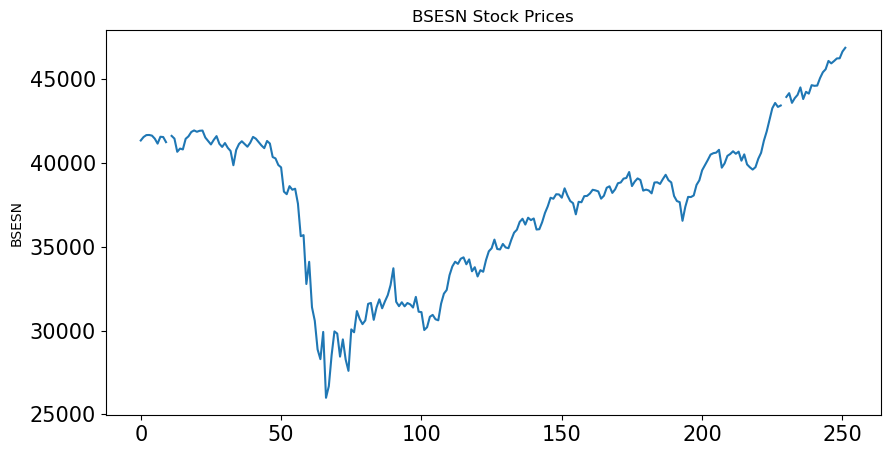

In [739]:
plt.figure(figsize=(10,5))
plt.title('BSESN Stock Prices')
plt.plot(df['Close'])
#plt.xlabel('Team')
# plt.xticks(np.arange(0,1000, 300), df['Date'][0:1000:300])
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.ylabel('BSESN')
plt.show()


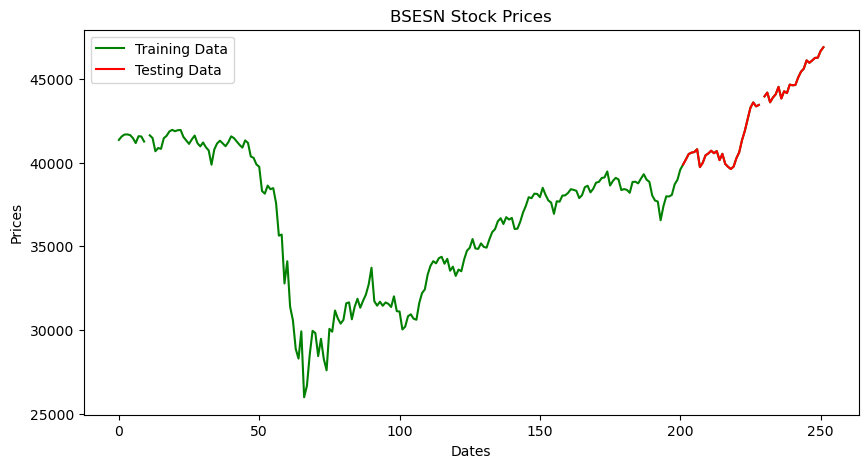

In [740]:
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
plt.figure(figsize=(10,5))
plt.title('BSESN Stock Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df['Close'], 'green', label='Training Data')
plt.plot(test_data['Close'], 'red', label='Testing Data')
#plt.xticks(np.arange(0,1500, 300), df['Date'][0:1500:300])
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.legend()


### Plot the Moving Average

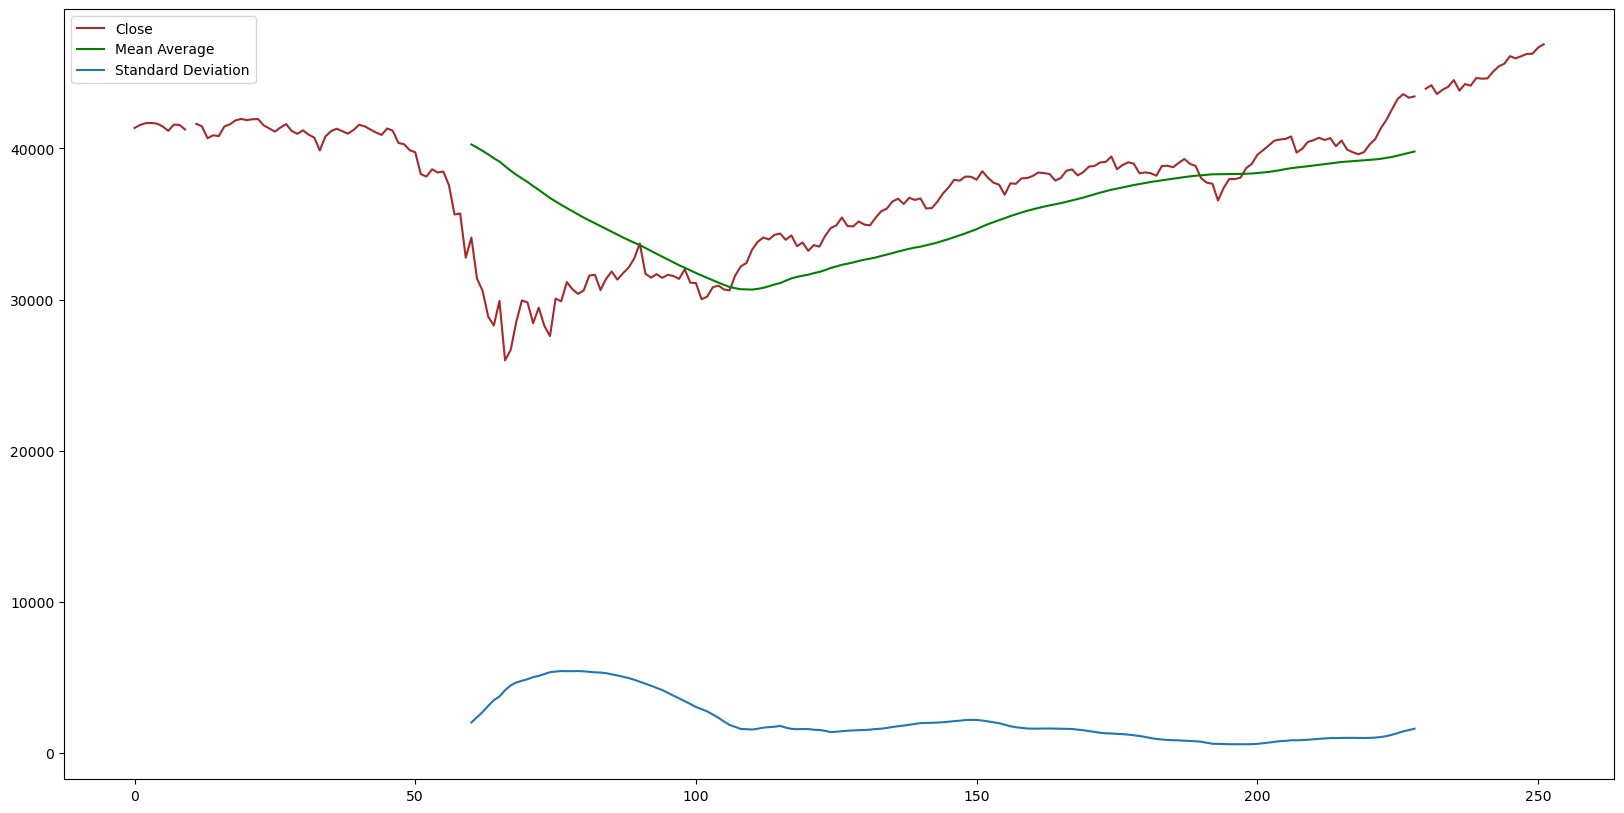

In [741]:
#Plotting moving average
close = df['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,10))
df['Close'].plot(color='brown',label='Close')
ma.plot(color = 'green',label='Mean Average')
std.plot(label = 'Standard Deviation')
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.legend()

### Plot the Returns

Text(0.5, 1.0, 'Returns')

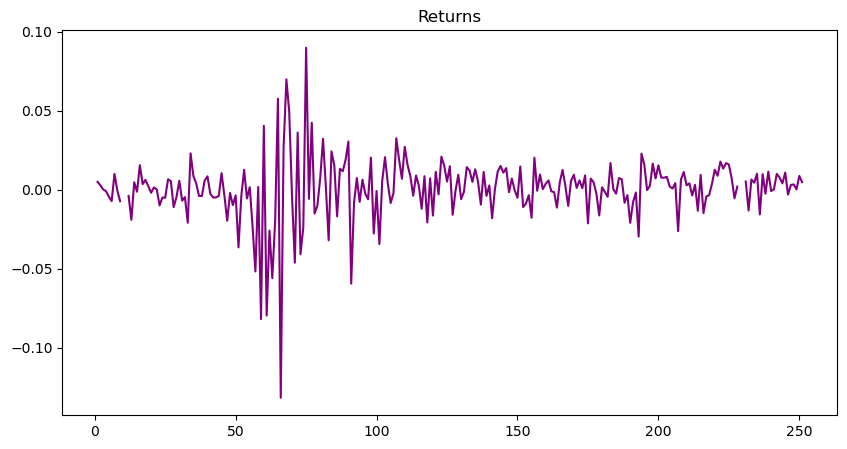

In [742]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,5))
returns.plot(label='Return', color = 'purple')
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Returns")

### TEXTUAL ANALYSIS

In [743]:
df_news= pd.read_csv(r'C:\GG\Internships\The Sparks Foundation (TSF)\Stock analysis\india-news-headlines.csv')
df_news

,Date,Category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic
...,...,...,...
244,20010104,unknown,Experts discuss horticulture development
245,20010104,unknown,5 acquitted in trespassing case
246,20010104,unknown,Development of horticulture stressed
247,20010104,unknown,New office-bearers for ICSI


In [744]:
# df_news.dropna(inplace=True)

df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()
     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 1 to 248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           248 non-null    int64 
 1   headline_text  248 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.0+ KB


### Converting the data type of Date Column

In [745]:
 #Converting data type of Date column 
 df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
 df_news

,Date,headline_text
1,2001-01-02,Fissures in Hurriyat over Pak visit
2,2001-01-02,America's unwanted heading for India?
3,2001-01-02,For bigwigs; it is destination Goa
4,2001-01-02,Extra buses to clear tourist traffic
5,2001-01-02,Dilute the power of transfers; says Riberio
...,...,...
244,2001-01-04,Experts discuss horticulture development
245,2001-01-04,5 acquitted in trespassing case
246,2001-01-04,Development of horticulture stressed
247,2001-01-04,New office-bearers for ICSI


In [746]:
#Grouping the headlines for each day
df_news['headline_text'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,headline_text
0,2001-01-02,Fissures in Hurriyat over Pak visit America's ...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...


In [747]:
df_news['headline_text']

0    Fissures in Hurriyat over Pak visit America's ...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
Name: headline_text, dtype: object

In [748]:
#Cleaning headlines
c = []
for i in range(0,len(df_news['headline_text'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['headline_text'][i])
    news = news.lower()
    news = news.split()
    #news = [ps.stem(word) for word in news if not word in set(stopwords.words('word'))]
    news=' '.join(news)
    c.append(news)

In [749]:
df_news['News'] = pd.Series(c)
df_news

,Date,headline_text,News
0,2001-01-02,Fissures in Hurriyat over Pak visit America's ...,fissures in hurriyat over pak visit america s ...
1,2001-01-03,Powerless north India gropes in the dark Think...,powerless north india gropes in the dark think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,the string that pulled stephen hawking to indi...


In [750]:
#Calculating score for each news headline in the dataset
i=0 
compound_val = [ ] 
while i<len(df_news):
    
    k = analyser.polarity_scores(df_news.iloc[i]['headline_text'])
    compound_val.append(k['compound'])
    
    i = i+1
    
#converting sentiment values to numpy for easier usage
compound_val = np.array(compound_val)
len(compound_val)

3

In [751]:
df_news['VADER score'] = compound_val

In [752]:
df_news.head()

,Date,headline_text,News,VADER score
0,2001-01-02,Fissures in Hurriyat over Pak visit America's ...,fissures in hurriyat over pak visit america s ...,-0.9822
1,2001-01-03,Powerless north India gropes in the dark Think...,powerless north india gropes in the dark think...,-0.2640
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,the string that pulled stephen hawking to indi...,0.9708


In [753]:
# Calculating Sentiment value
i = 0
predicted_val = [ ]
while(i<len(df_news)):
    if ((df_news.iloc[i]['VADER score'] >= 0.1)):
        predicted_val.append('positive')
        i = i+1
    elif ((df_news.iloc[i]['VADER score'] > -0.1) & (df_news.iloc[i]['VADER score'] < 0.1)):
        predicted_val.append('neutral')
        i = i+1
    elif ((df_news.iloc[i]['VADER score'] <= -0.1)):
        predicted_val.append('negative')
        i = i+1

In [754]:
df_news['sentiment'] = predicted_val
df_news.head()

,Date,headline_text,News,VADER score,sentiment
0,2001-01-02,Fissures in Hurriyat over Pak visit America's ...,fissures in hurriyat over pak visit america s ...,-0.9822,negative
1,2001-01-03,Powerless north India gropes in the dark Think...,powerless north india gropes in the dark think...,-0.2640,negative
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,the string that pulled stephen hawking to indi...,0.9708,positive


In [755]:
df_news.sentiment.value_counts()

negative    2
positive    1
Name: sentiment, dtype: int64

In [756]:
#df_merge = pd.merge(df, df_news, how='left', on='Date')
#print(df_merge)

In [757]:
#news_df=df_merge[['Date','headline_text']]
#news_df

### Understanding of data types of the features.

In [758]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [759]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['headline_text'].apply(getSubjectivity)
df_news['Polarity'] = df_news['headline_text'].apply(getPolarity)
df_news

,Date,headline_text,News,VADER score,sentiment,Subjectivity,Polarity
0,2001-01-02,Fissures in Hurriyat over Pak visit America's ...,fissures in hurriyat over pak visit america s ...,-0.9822,negative,0.282333,0.151333
1,2001-01-03,Powerless north India gropes in the dark Think...,powerless north india gropes in the dark think...,-0.2640,negative,0.407692,0.088462
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,the string that pulled stephen hawking to indi...,0.9708,positive,0.444962,0.121856


<Axes: >

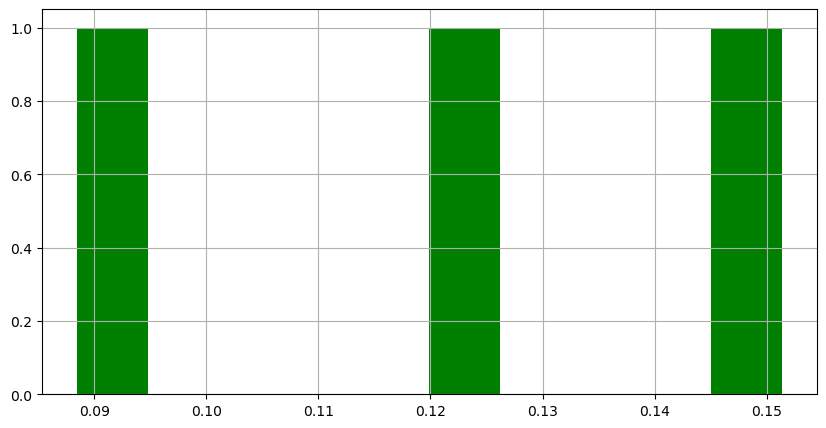

In [760]:
plt.figure(figsize = (10,5))
df_news['Polarity'].hist(color = 'green')
#data['smoker'].value_counts().plot(kind = 'bar', rot = 0)

<Axes: >

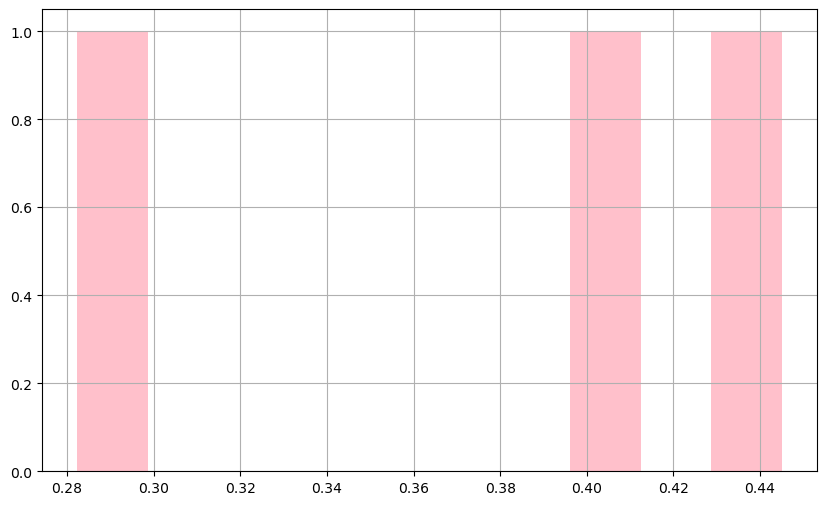

In [761]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'pink')

In [762]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

#df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['headline_text]]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['headline_text']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['headline_text']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['headline_text']]
df_news

,Date,headline_text,News,VADER score,sentiment,Subjectivity,Polarity,Negative,Neutral,Positive
0,2001-01-02,Fissures in Hurriyat over Pak visit America's ...,fissures in hurriyat over pak visit america s ...,-0.9822,negative,0.282333,0.151333,0.125,0.806,0.069
1,2001-01-03,Powerless north India gropes in the dark Think...,powerless north india gropes in the dark think...,-0.2640,negative,0.407692,0.088462,0.122,0.766,0.111
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,the string that pulled stephen hawking to indi...,0.9708,positive,0.444962,0.121856,0.097,0.787,0.117


In [763]:
df_merge = pd.merge(df, df_news, how='inner', on='Date')
df_merge

,Date,Close,headline_text,News,VADER score,sentiment,Subjectivity,Polarity,Negative,Neutral,Positive


In [764]:
df_merge = pd.merge(df, df_news, how='left', on='Date')
df_merge

,Date,Close,headline_text,News,VADER score,sentiment,Subjectivity,Polarity,Negative,Neutral,Positive
0,2019-12-17,41352.171875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-12-18,41558.570313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-12-19,41673.921875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-12-20,41681.539063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-23,41642.660156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
247,2020-12-11,46099.011719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,2020-12-14,46253.460938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249,2020-12-15,46263.171875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,2020-12-16,46666.460938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [765]:
df = df_merge[['Close','Subjectivity', 'Polarity']]
df   

,Close,Subjectivity,Polarity
0,41352.171875,NaN,NaN
1,41558.570313,NaN,NaN
2,41673.921875,NaN,NaN
3,41681.539063,NaN,NaN
4,41642.660156,NaN,NaN
...,...,...,...
247,46099.011719,NaN,NaN
248,46253.460938,NaN,NaN
249,46263.171875,NaN,NaN
250,46666.460938,NaN,NaN


In [766]:
df_merge = df_merge.dropna()

In [767]:
df_merge_filled_zero = df_merge.fillna(0)

In [768]:
df_merge_filled_empty = df_merge.fillna('')

In [769]:
df_merge_ffill = df_merge.ffill()

In [770]:
df_merge_bfill = df_merge.bfill()

In [771]:
print("Original Merged DataFrame:\n", df_merge)
#print("After Dropping NaN Values:\n", df_merge_dropped)
print("After Filling NaN Values with 0:\n", df_merge_filled_zero)
print("After Filling NaN Values with Empty String:\n", df_merge_filled_empty)
print("After Forward Filling NaN Values:\n", df_merge_ffill)
print("After Backward Filling NaN Values:\n", df_merge_bfill)

Original Merged DataFrame:
 Empty DataFrame
Columns: [Date, Close, headline_text, News, VADER score, sentiment, Subjectivity, Polarity, Negative, Neutral, Positive]
Index: []
After Filling NaN Values with 0:
 Empty DataFrame
Columns: [Date, Close, headline_text, News, VADER score, sentiment, Subjectivity, Polarity, Negative, Neutral, Positive]
Index: []
After Filling NaN Values with Empty String:
 Empty DataFrame
Columns: [Date, Close, headline_text, News, VADER score, sentiment, Subjectivity, Polarity, Negative, Neutral, Positive]
Index: []
After Forward Filling NaN Values:
 Empty DataFrame
Columns: [Date, Close, headline_text, News, VADER score, sentiment, Subjectivity, Polarity, Negative, Neutral, Positive]
Index: []
After Backward Filling NaN Values:
 Empty DataFrame
Columns: [Date, Close, headline_text, News, VADER score, sentiment, Subjectivity, Polarity, Negative, Neutral, Positive]
Index: []


In [772]:
df_news=df_merge[['Close','sentiment']]
df_news

,Close,sentiment


In [773]:
df_news.groupby(['sentiment']).mean()

,Close
sentiment,
